# Exercício 03

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

## Redução de dimensionalidade

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser achados em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [2]:
# Importando o dataset:
data = torch.from_numpy(pd.read_csv("./penguins.csv", header=None).to_numpy())

Variância explicada: 99.38%


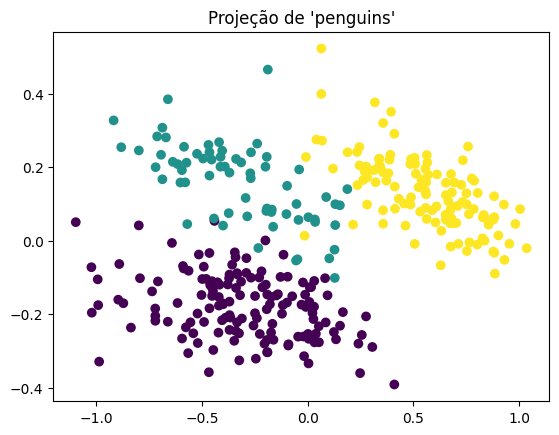

In [66]:
# Função para calcular a projeção do PCA
def pca(data, num_principal_components):
    # Normalizando as variáveis
    means_data = torch.mean(data, dim = 0)
    variances_data = torch.var(data, dim = 0)
    normalized_data = (data - means_data) / variances_data

    # Calculando a matriz de covariância e seus autovalores e autovetores
    cov_matrix = normalized_data.T.cov()
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

    # Pegando os componentes principais como os autovetores de maiores autovalores
    principal_components = eigenvectors[-num_principal_components:, :]

    # Calculando a variância explicada
    explained_variation = torch.sum(eigenvalues[-num_principal_components:])/torch.sum(eigenvalues)
    print(f"Variância explicada: {round(explained_variation.item(), 5) * 100}%")

    # Projetando os dados
    projected_data = normalized_data @ principal_components.T

    return projected_data

# Pegando as colunas dos padrões
patterns = data[:, :-1]

projected_data = pca(patterns, 2)

plt.scatter(projected_data[:, 0], projected_data[:, 1], c = data[:, -1])
plt.title("Projeção de 'penguins'")
plt.show()

In [67]:
for num_principal_components in range(1, 5):
    pca(patterns, num_principal_components)

Variância explicada: 88.289%
Variância explicada: 99.38%
Variância explicada: 100.0%
Variância explicada: 100.0%


**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [50]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

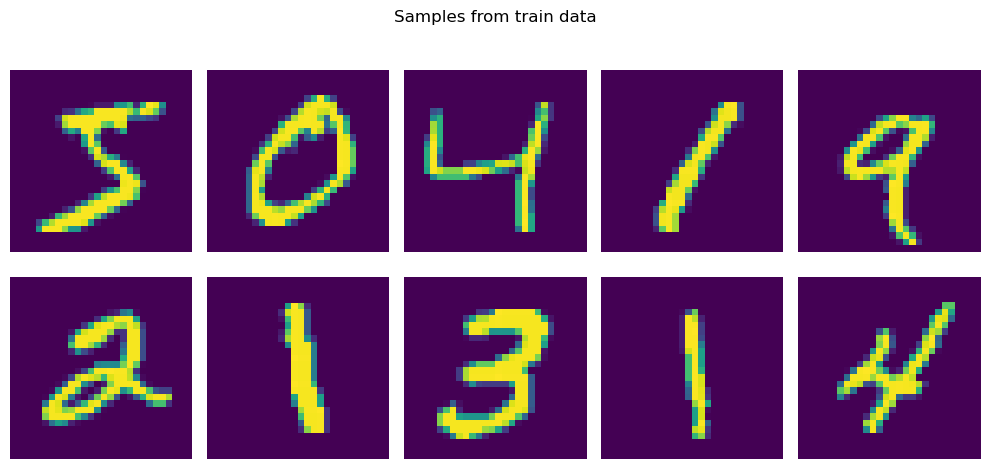

In [48]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()

## K-means e Mixture models

## Exercícios práticos

In [12]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [10]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

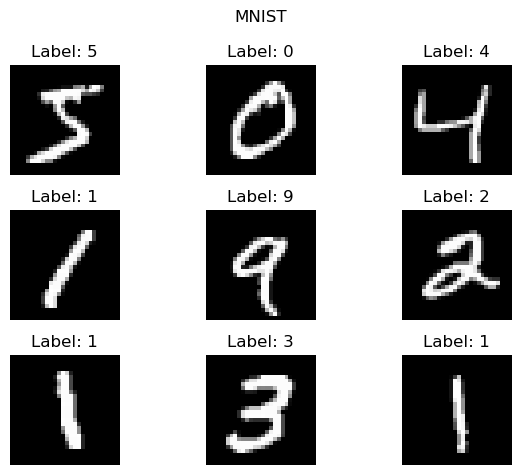

In [11]:
display_nine_images(mnist_trainset)

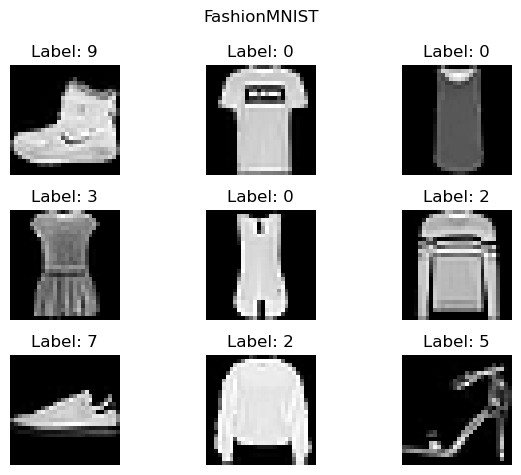

In [7]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

## Modelos baseados em energia (EBM)

(-7.0, 7.0)

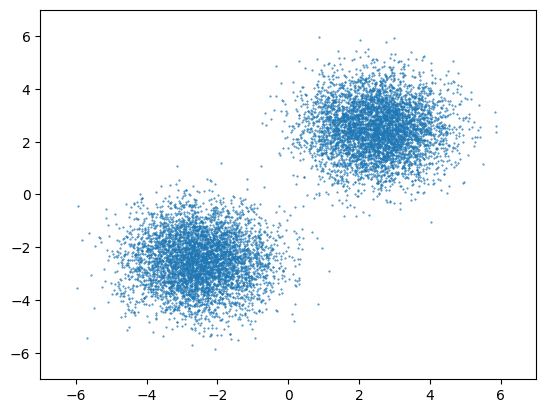

In [32]:
import torch
import torch.nn as nn
import torch_sgld
import seaborn as sns
import matplotlib.pyplot as plt

N = 10000
d = 2
data = torch.randn((int(N/2),d)) + 2.5
data2 = torch.randn((int(N/2),d)) - 2.5
data = torch.cat((data, data2), dim=0)


plt.scatter(data[:,0], data[:,1], s=0.2)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

**1.** Considere as a amostras da distribuição acima, contidas na variável 'data'. Complete o código abaixo para implementar um modelo baseado em energia (EBM) que amostre aproximadamente da distribuição subjacente a esses dados. Depois de treinar o modelo, amostre do EBM e compare o resultado contra o scatterplot acima. Analise o efeito de mudar a quantidade de iterações de SGLD por época. Além disso, a implementação abaixo usa cadeias 'persistentes' entre épocas --- i.e., o estado final da última época é o inicial da atual. Qual o efeito de inicializar aleatoriamente a cadeia em cada iteração? E de inicializá-las nos pontos observados em 'data'?

In [69]:
h = 10
E = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, h), nn.ReLU(),nn.Linear(h, 1)).to('cuda')
data = data.to('cuda')

max_iter = 100000


x = torch.randn((N,2), device='cuda')*5.0
x.requires_grad=True
optimizer = torch.optim.Adam(E.parameters(), lr=0.01)
sampler = torch_sgld.SGLD([x], lr=0.01) 

chain_length=10

for i in range(max_iter):
    for i in range(chain_length):
        sampler.zero_grad()
        potential = # TODO
        potential.sum().backward()
        sampler.step()
    optimizer.zero_grad()
    loss = # TODO
    loss.backward()
    optimizer.step()


**2.** Treine um EBM via máxima verossimlhança usando o MNIST. Mostre as amostras geradas pelo modelo. Crie um conjunto de amostras do EBM e mostre o histograma de suas respectivas energias. Mostre e comente alguns exemplos de amostras de alta e de baixa energia.